<table><tr>
<td> <img src="Images/Multiverse-logo.jpg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

# Quantum Approximate Optimization Algorithm (QAOA) for the Max-cut problem

### **Victor Onofre**

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

In [2]:
style = {'backgroundcolor': 'lightyellow'} # Style of the drawing of the quantum circuit 

# Part I: Max-cut problem 

Given a graph  $G = (V, E)$ where:

- $V$ is the set of vertices/nodes
- $E$ is the set of edges

Each edges $e \in E$ is a pair $\{u,v\}$ where $v \in V$ are distinct

####  Example of a graph: 

$$ V = {1,2,3}$$
$$ E = \{\{1,2\}, \{2,3\}, \{1,3\} \} $$

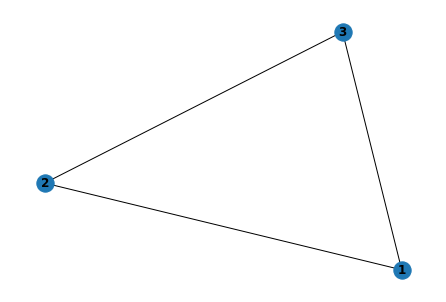

In [3]:
Graph_Example_1 = nx.Graph()
Graph_Example_1.add_edges_from([[1,2],[2,3],[1,3]])
nx.draw(Graph_Example_1,with_labels=True,font_weight='bold')

The goal of the max-cut problem is to:

> **Have as many cut edges as possible. Where an edge is cut if its endpoints have different colors**

The output is a "2-coloring" of $V$: Each vertex is designated a color (examples: blue or red)

The maximum cut can be formaulated as an optimization problem:

$$ \max_{s}\frac{1}{2} \sum_{ij \in E}  (1-s_{i}s_{j}), \quad s_{i} \in \{-1 , +1 \}$$

> Same sign: No edge is cut (no contribution to the objective function) $\rightarrow \frac{1}{2} (1-s_{i}s_{j}) = 0$

> Different sign: An edge is cut (contribution to the objective function) $\rightarrow \frac{1}{2} (1-s_{i}s_{j}) = 1$

###  Examples of solutions to the max-cut problem:

In the triangular graph the solution to the max-cut problem is:

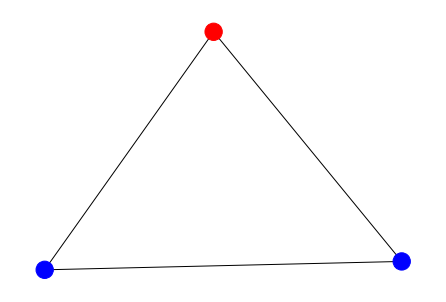

In [4]:
nx.draw(Graph_Example_1,node_color = ['b','b','r'])

Where we a maximum of $2$ cuts. If we assign a string to the colors in the graph we can represent this solution as: $001$. 
> Where $0$ is the node blue and $1$ the node is red

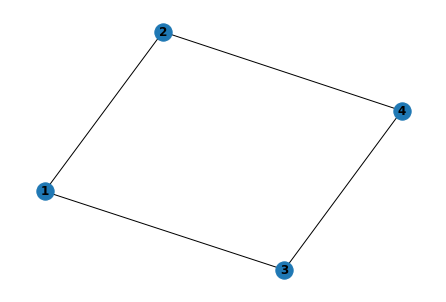

In [6]:
Graph_Example_2 = nx.Graph()
Graph_Example_2.add_edges_from([[1,2],[1,3],[4,2],[4,3]])
nx.draw(Graph_Example_2,with_labels=True,font_weight='bold')

In this example the solution to the max-cut problem is:

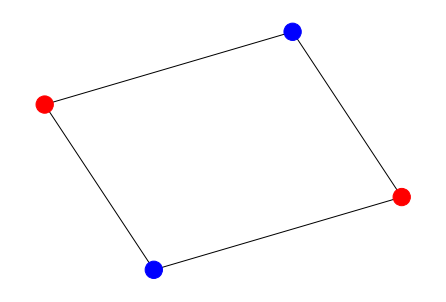

In [7]:
nx.draw(Graph_Example_2,node_color = ['r','b','b','r'])

Where we have $4$ cuts. Represented in string as: 1001

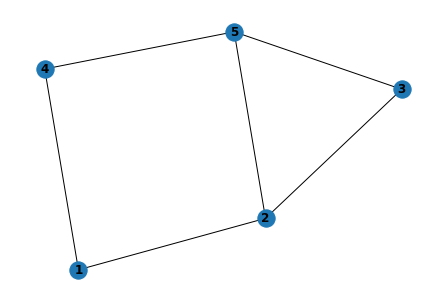

In [8]:
Graph_Example_3 = nx.Graph()
Graph_Example_3.add_edges_from([[1,4],[1,2],[2,5],[4,5],[5,3],[2,3]])
nx.draw(Graph_Example_3,with_labels=True,font_weight='bold')

In this example the solution to the max-cut problem is:

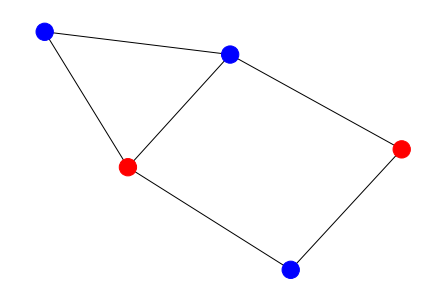

In [10]:
nx.draw(Graph_Example_3,node_color = ['r','b','b','r','b'])

Where, the best solution for the max-cut problem is $5$ cuts. Represented by the string: $10001$ 

- The problem of cluster analysis, partitioning a set of data points into groups of "closely related" observations, can be modeled as a maximum cut problem. The points in a particular group, or cluster, should be more "similar" or "close" to each other than they are to points in other clusters. 
- Cluster analysis can be formulated as a maximum cut problem by creating a graph that contains a node for each data point and an edge between each pair of points. The weight of the edge is determined by the relative "closeness" of the points represented by the nodes it connects. 
- For numerical data, for example, the relative closeness may be defined as the Euclidean distance. The clusters that are formed by finding maximum weight cuts in this graph have the property that points in one cluster are more dissimilar from points in other clusters.
- The maxcut problems also arises in the design of VLSI circuits and the analysis of spin-glass models. 

<table><tr>
<td> <img src="Images/layout1.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="Images/layout2.png" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

# Part II: Quantum Approximate Optimization Algorithm (QAOA )

<img src="Images/diagrama1.png">

We wish to maximize an objective function:
    
$$ C = \sum_{k=1}^{m} c_{m}(z), \quad  z=z_{1}z_{2}z_{3}...z_{n} \quad z_{k} \in \{0,1\}^{n} $$

$c_{m} \in \{0,1\}$ is a function that queries string $z$ to see if the substring satisfies certain property.

The first step for the QAOA is to treat the objective fucntion $C$ as an operator

$$C |z> = \sum_{k=1}^{m} c_{k}(z)|z> = f(z)|z>$$

$C$ has eigenvectors $|z>$ and eigenvalues $\sum_{k=1}^{m}c_{k}(z) = f(z)$

The largest value $f(z)$, which can denote $f(z')$ is the $C_{max}$ with corresponding eigenvector $|z'>$

With the basis $|z>$, we can construct a general superposition state:

$$|\psi> = \sum_{z \in \{0, 1\}^{n} } a_{z} |z>$$ 

For $|\psi>$ we can construct the expectation value of $C$, that is:

$$<C> = < \psi | C |\psi > $$

If $|\psi> = |z> \rightarrow <C> = <z|C|z> = f(z)$. Finding the $|z>$ that can maximizae $C(z)$ is corresponding to finding a state $|\psi>$ that maximize $<C>$.

So $<C>_{max} = f(z')$ only when $|\psi> = |z'>$. This means that if we can obtain $<C>_{max}$, we are applying $|z'>$, if we measure the state $|\psi>$ in the $|z>$ basis we will obtain $|z'>$ with probability 1. 

> In general, we don't known how to find such $<C>_{max}$ efficiently, we can only find a $<C>$ that is close to $<C>_{max}$

We can rotate  our initial state $|s>$ to make it closer to the $|z'>$. To do this we define two types of ratations operators:

$$ U(C,\gamma) = e^{-i \gamma C}, \quad U(B,\beta) = e^{-i \beta B}$$

It is not guarantedd that after 

$$|\psi'> = U(B, \beta)U(C,\gamma)|\psi>, \quad  U(B, \beta)=e^{-i\beta B}  \quad U(C,\gamma) = e^{-i\gamma C}$$

the new state $|\psi'>$ is close enough to $|z'>$. A solution to this is to apply $U(B, \beta)U(C,\gamma)$ multiply times with different $\beta$ and $\gamma$ each time.

QAOA prepares an ansatz state of the form:
    
$$|\psi(\boldsymbol{\theta}) > = |\psi(\boldsymbol{\beta,\gamma}) > = e^{-i\beta_{p}B} e^{-i\gamma_{p}C}... e^{-i\beta_{1}B} e^{-i\gamma_{1}C} H^{\otimes n}|0>$$    

Maxcut hamiltonian is constructed by mapping the binary variables $s_{i}$ onto the eigenvalues of $z$

$$C = \frac{1}{2} \sum_{ij \in E} (I - Z_{i}Z_{j})$$

B is the mixer hamiltonian:

$$ B = \sum_{i} x_{i}$$

Then a classical optimizer is used to vary the parameters $\boldsymbol{\beta}, \boldsymbol{\gamma}$ to maximize the function:

$$f(\boldsymbol{\beta,\gamma}) = <\psi(\boldsymbol{\beta,\gamma}) |C|\psi(\boldsymbol{\beta,\gamma})>$$

**The quality of QAOA solution heavily depends on the quality of the parameters found by the classical optimizer**

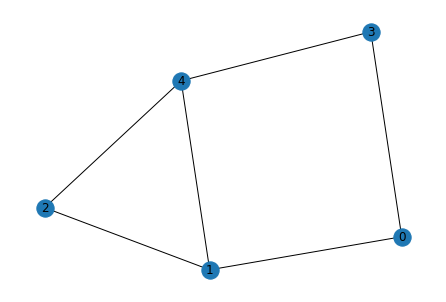

In [12]:
Graph = nx.Graph()
Graph.add_edges_from([[0,1],[0,3],[3,4],[1,4],[1,2],[4,2]])
nx.draw(Graph,with_labels=True)

### Construct the operator $U(B, \beta) = exp(-i \gamma_{p}C)$

$$U(C,\gamma)= e^{-i\gamma_{p}C} = e^{-i\gamma_{p}(Z_{i} \otimes Z_{j})} $$

$$|\Psi> = a_{00}|00> + a_{01} |01> + a_{10}|10> + a_{11} |11> $$

$$e^{-i\gamma_{p}(Z_{i} \otimes Z_{j})} |\Psi> = a_{00}e^{-i\gamma_{p}(Z_{i} \otimes Z_{j})} |00> + a_{01} e^{-i\gamma_{p}(Z_{i} \otimes Z_{j})} |01> + a_{10}e^{-i\gamma_{p}(Z_{i} \otimes Z_{j})} |10> + a_{11} e^{-i\gamma_{p}(Z_{i} \otimes Z_{j})} |11>$$

$$e^{-i\gamma_{p}(Z_{i} \otimes Z_{j})} |\Psi> = a_{00}e^{-i\gamma_{p}} |00> + a_{01} e^{i\gamma_{p}} |01> + a_{10}e^{i\gamma_{p}} |10> + a_{11} e^{-i\gamma_{p}} |11>$$

The operator adds a phase factor with the sign depneding on parity, in general:
    
$$ e^{-i\gamma_{p}(Z_{i} \otimes Z_{j})} |ab> =e^{-i\gamma_{p}(-1)^{a \oplus b}} |ab>   $$

This operator can be construct with the quantum gates:
$$CNOT_{ij}[ I\otimes R_{z}(\theta) ]CNOT_{ij} $$

In [13]:
Graph.edges()

EdgeView([(0, 1), (0, 3), (1, 4), (1, 2), (3, 4), (4, 2)])

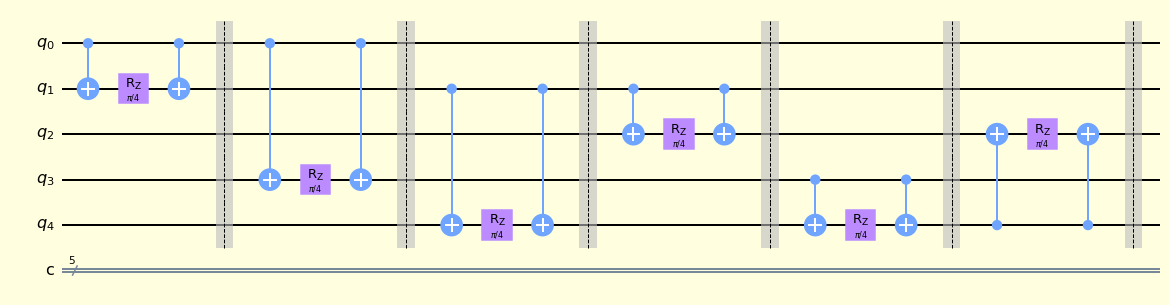

In [14]:
N = Graph.number_of_nodes() # The number of nodes in the graph
qc = QuantumCircuit(N,N) # Quantum circuit with N qubits and N classical register

gamma = np.pi/8 # parameter gamma for the cost function (maxcut hamiltonian)
#Apply the operator to each edge
for i, j in Graph.edges(): 
    qc.cx(i,j)
    qc.rz(2*gamma, j)
    qc.cx(i,j)
    qc.barrier()
    
qc.draw(output='mpl', style=style) # Draw the quantum circuit

### Construct the operator $U(B, \beta)=exp(-i \beta_{p}B)$

$$ B = \sum_{i} X_{i}$$

$$U(B, \beta) = e^{-i\beta_{p}B} = e^{-i\beta_{p} \sum_{i} X_{i}} =  	\prod_{i=1}^{n} e^{-i\beta_{p} X_{i}} $$

This operator can be constructed with a rotation operator $R_{x}(\theta) = e^{-i \theta/2 X}$

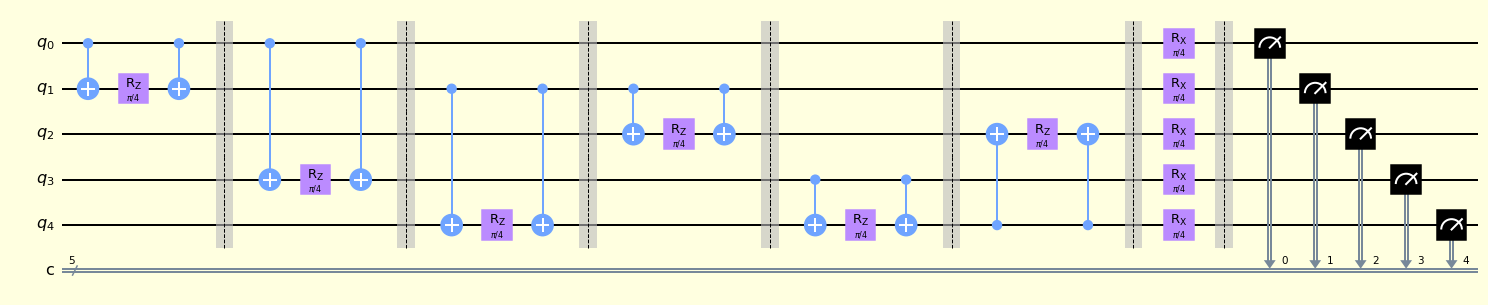

In [15]:
beta = np.pi/8 # parameter for the mixer hamiltonian
for n in Graph.nodes():
    qc.rx(2*beta, n)

# measure the result
qc.barrier(range(N))
qc.measure(range(N), range(N))

qc.draw(output='mpl', style=style,fold= 35) 

<img src="Images/Operators.png">

In [16]:
def qaoa_circuit(G, theta,p):
    r"""
    ############################################
    # Compute the QAOA circuit for the graph G
    #
    # |psi(theta) > = |psi(beta,gamma) > = e^{-i*beta_p*B} e^{-i*gamma_p*C}... e^{-i*beta_1*B} e^{-i*gamma_1*C} H^{otimes n}|0>
    # 
    # where C is the Maxcut hamiltonian, B is the mixer hamiltonian.
    #
    # G: graph
    # theta: parameters,first half is betas, second half is gammas
    # p: number of QAOA steps
    # return: The QAOA circuit 
    ###########################################
    """
    beta = theta[:p] #Parameters beta for the mixer hamiltonian
    gamma = theta[p:]#Parameters gamma for the maxcut hamiltonian
    N = G.number_of_nodes()#Number of nodes of the graph G
    qc = QuantumCircuit(N,N)# Quantum circuit wiht N qubits and N classical register
    qc.h(range(N))# Apply the Hadamard gate to all the qubits
    # Apply p operators
    for k in range(p):
        for i, j in G.edges(): #Representation of the maxcut hamiltonian
            qc.cx(i,j)  
            qc.rz(2*gamma[k], j)
            qc.cx(i,j)
            qc.barrier()
        for n in G.nodes(): # Representation of the mixer hamiltonian
            qc.rx(2*beta[k], n)
    # Measurement in all the qubits
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc #Returns the quantum circuit

In [17]:
# p is the number of QAOA alternating operators
p = 1

theta = np.array([np.pi/8,np.pi/8])

circuit = qaoa_circuit(Graph, theta,p)

<img src="Images/example1.jpeg">

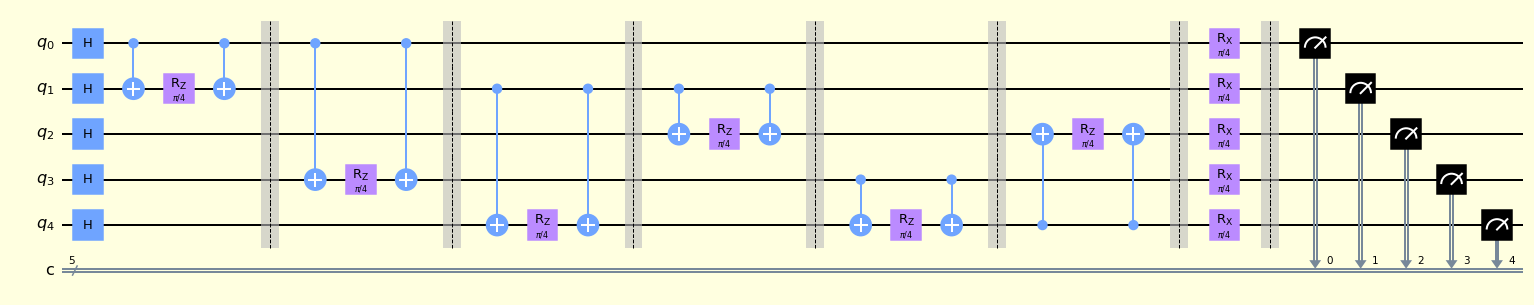

In [18]:
circuit.draw(output='mpl', style=style,fold= 35) # Draw the quantum circuit

# Part III: Optimization

In [26]:
#Qiskit uses the least significant bit in the bistring, we need to invert this string
def invert_counts(counts):
    r"""
    ############################################
    # Inverted the binary string
    #
    # counts: The result of running the quantum circuit
    # return: The results with binary string inverted
    ###########################################
    """
    inv_counts = {}
    for k, v in counts.items():
        inv_counts[k[::-1]] = v
    return inv_counts 

In [27]:
def maxcut_objective_function(x,G):
    r"""
    ############################################
    # Compute the maxcut objective function for the binary string x and graph G
    #
    # G: graph
    # x: binary string
    # return: The cost of the binary string x 
    ###########################################
    """
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            cut -= 1# the edge is cut
    return cut # Sum of all the edges that are cut

In [28]:
def function_to_minimize(G,p):
    r"""
    ############################################
    # Define the function to minimize given the graph G and the number of parameters
    #
    # G: graph
    # p: number of parameters
    # return: The function to minimize
    ###########################################
    """
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        r"""
        ############################################
        # Function that gives the energy for parameters theta
        #
        # theta: parameters
        # return: Energy
        ###########################################
        """
        qc = qaoa_circuit(G,theta,p) # Gives the circuit of QAOA fot a graph G, parameters theta and p operators
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()# Run the circuit and get the results using the backedn "qasm_simulator"
        
        E = 0 # Initial energy
        total_counts = 0 # Initial counts
        #Qiskit uses the least significant bit in the bistring, we need to invert this string
        InvertedCounts = invert_counts(counts) #Inverted the binary string
        # meas is the binary string measure
        # meas_count is the number of times that the binary string has been measure
        for meas, meas_count in InvertedCounts.items():
            objective_function = maxcut_objective_function(meas, G)#Compute the maxcut objetive function fot the binary string meas
            E += objective_function*meas_count # Define the energy as the value of the objective functions times the counts of that measure
            total_counts += meas_count # The total number of measures in the system
        return E/total_counts # Returns the energy given the parameters theta
    return f

In [29]:
p = 5 # p is the number of QAOA alternating operators
objective_function = function_to_minimize(Graph, p)
x0=np.random.randn(10)#Initial parameters

minim_solution = minimize(objective_function, x0) # Minimization of scalar function of one or more variable from scipy
minim_solution

      fun: -3.1240234375
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-0.79182935, -0.81005036,  0.3351553 , -0.62877493,  0.38573358,
       -0.14318688, -0.03343385, -0.4613475 , -0.80825018,  1.25235699])

In [30]:
optimal_theta = minim_solution['x'] # The optimal parameters to use

In [31]:
optimal_theta

array([-0.79182935, -0.81005036,  0.3351553 , -0.62877493,  0.38573358,
       -0.14318688, -0.03343385, -0.4613475 , -0.80825018,  1.25235699])

In [42]:
backend = Aer.get_backend('qasm_simulator')
qc = qaoa_circuit(Graph, optimal_theta,p) # Define the quantum circuit with the optimal parameters
counts = invert_counts(execute(qc, backend).result().get_counts()) # Get the results
#energies = {bs: maxcut_objective_function(bs, Graph) for bs, _ in counts.items()}
#energies_sorted = {bs: en for bs, en in sorted(energies.items(), key=lambda item: item[1])}
#print(energies_sorted)
#print({bs: counts[bs] for bs, energy in energies_sorted.items()})

In [27]:
# Compute the maxcut objective function for the optimal parameters
results = []
for x in counts.keys():
    results.append([maxcut_objective_function(x,Graph),x]) 

In [28]:
# Get the best solution given the results of the maxcut objective function
best_cut, best_solution = min(results)
print(f"Best string: {best_solution} with cut: {-best_cut}")

Best string: 01010 with cut: 5


In [29]:
# Define the colors of the nodes for the best solution
colors = ['r' if best_solution[node] == '0' else 'b' for node in Graph]

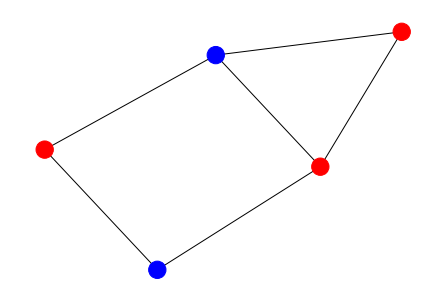

In [30]:
nx.draw(Graph,node_color = colors)

# Part IV: General Case

In [31]:
def solution_max_cut(G):
    r"""
    ############################################
    # Compute the solution for the maxcut problem given a graph G
    #
    # G: graph
    # return:The draw of the best solution with two colors. Print the solution in the binary string form and the number of cuts 
    ###############
    """
    p = 5 # p is the number of QAOA alternating operators
    objective_function = function_to_minimize(G, p)
    x0=np.random.randn(10)#Initial parameters

    new_parameters = minimize(objective_function, x0) # Minimization of scalar function of one or more variable from scipy
    
    optimal_theta = new_parameters['x']# The optimal parameters to use
    qc = qaoa_circuit(G, optimal_theta,p) # Define the quantum circuit with the optimal parameters
    counts = invert_counts(execute(qc, backend).result().get_counts()) # Get the results
    
    # Compute the maxcut objective function for the optimal parameters
    results = []
    for x in counts.keys():
        results.append([maxcut_objective_function(x,G),x])
        
    best_cut, best_solution = min(results) # Get the best solution given the results of the maxcut objective function
    colors = ['r' if best_solution[node] == '0' else 'b' for node in G] # Define the colors of the nodes for the best solution
    return nx.draw(G,node_color = colors),print(f"Best string: {best_solution} with cut: {-best_cut}")

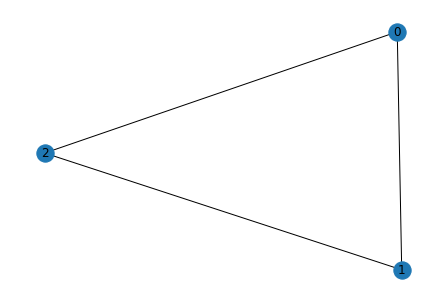

In [32]:
Graph1 = nx.Graph()
Graph1.add_edges_from([[0,1],[0,2],[2,1]])
nx.draw(Graph1,with_labels=True)

Best string: 001 with cut: 2


(None, None)

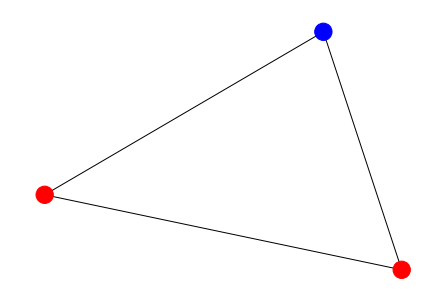

In [33]:
solution_max_cut(Graph1)

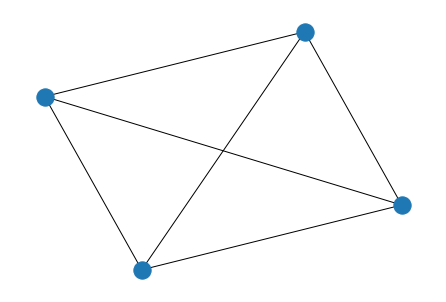

In [34]:
graph2 = nx.random_regular_graph(3, 4, seed=1234)
nx.draw(graph2)          #drawing the graph
plt.show()              #plotting the graph

Best string: 0011 with cut: 4


(None, None)

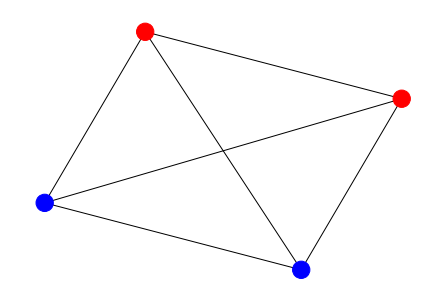

In [35]:
solution_max_cut(graph2)

# **Solution for a random graph of 12 nodes**

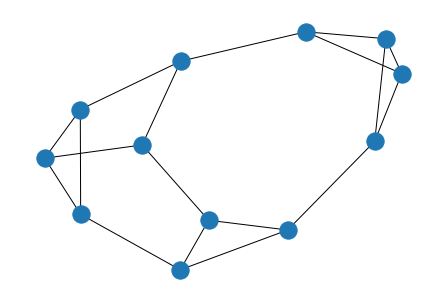

In [36]:
graph3 = nx.random_regular_graph(3, 12, seed=1234)
nx.draw(graph3)          #drawing the graph
plt.show()              #plotting the graph

Best string: 010100010101 with cut: 13


(None, None)

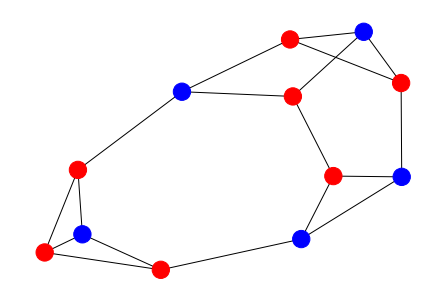

In [37]:
solution_max_cut(graph3)

## References

[1] https://arxiv.org/abs/1411.4028

[2] https://www.cs.umd.edu/class/fall2018/cmsc657/projects/group_16.pdf

[3] https://ieeexplore.ieee.org/document/8939749

[4] https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained

[5] F. Barahona, M. Grötschel, M. Jünger and G. Reinelt, "An Application of Combinatorial Optimization to Statistical Physics and Circuit Layout Design," Operations Research, 3:493-513 (1988). https://www.zib.de/groetschel/pubnew/paper/barahonagroetscheljuengeretal1988.pdf 

[6] Rui-Sheng Wang, Li-Min Wang, "Maximum cut in fuzzy nature:Models and algorithms", https://www.sciencedirect.com/science/article/pii/S0377042709008309 

[7] Alam, Mahabubul, Abdullah Ash-Saki, and Swaroop Ghosh. "Analysis of quantum approximate optimization algorithm under realistic noise in superconducting qubits." arXiv preprint arXiv:1907.09631 (2019).